<a href="https://colab.research.google.com/github/NPMachineLearning/ML_Workout_Colab/blob/master/ML_Workout_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
! pip install --user -U -q tensorflow
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
from tqdm import tqdm
from shutil import rmtree
import pathlib
import cv2
import warnings

!pip install --user -U -q patool
import patoolib

# Global var definition

Define global variables

In [2]:
# Directory configs
DATASET_ROOT_DIR = "datasets"
DATASET_DOWNLOAD_DIR = os.path.join(DATASET_ROOT_DIR, "download")
DATASET_FILE_NAME = "ucf101.zip"
DATASET_DIR = os.path.join(DATASET_ROOT_DIR, "ucf101")

# Dataset configs
EXTRACT_SIZE = 0.1

# Tensorflow dataset configs
BATCH_SIZE = 64
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 32
CLASSES = ["PullUps", "BodyWeightSquats", "PushUps"]

# Tensorflow model training
EPOCHS = 30

# Tensorflow model saved dir
SAVE_MODEL_ROOT_DIR = "Saved_models"
TF_MODEL_DIR = "tf_pose_recognizer"
TFLITE_MODEL_DIR = "tf_lite_pose_recognizer"

# Helper functions & classes

## Download file

In [ ]:
def download_file(url, file_path, chunk_size=1024, ssl_verify=False):
  """
  Download file and save to directory
  
  Args:
    * `url`: `string` url to file in internet
    * `file_path`: `string` file path where file will be saved
      Note: must include full file name with extension
    * `chunk_size`: `int` chunk size for stream downloading
    * `ssl_verify`: refer to https://requests.readthedocs.io/en/latest/user/advanced/#ssl-cert-verification 
  """
  try:
    r = requests.get(url, stream=True, verify=ssl_verify)
    file_len = int(r.headers.get('content-length', 0))
    with open(file_path, "wb") as f, tqdm(
        desc=url,
        total=file_len,
        unit='iB',
        unit_scale=True,
        unit_divisor=chunk_size,
    ) as bar:
      for chunk in r.iter_content(chunk_size=chunk_size):
        if chunk:
          size = f.write(chunk)
          bar.update(size)
  except Exception as e:
    print(e)

## Get file path from directory

Return list of file path in directory

In [ ]:
def get_file_paths(dir, pattern="**/*.*"):
  """
  Return all files' path under a directory 
  
  Args:
    * `dir`: `string` directory path to search
    * `pattern`: `string` file name pattern.
      e.g `file_name_*.avi` will return all avi file's
      path and file name prefix with `file_name_`.
      Refer to https://docs.python.org/3/library/pathlib.html

  Return:
    Numpy array of file paths
  """
  # if dir does not exists
  if not os.path.isdir(dir):
    raise Exception(f"{dir} doesn't exists")
  
  # find all file path
  file_paths = []
  paths = pathlib.Path(dir).glob(pattern)
  for p in paths:
    file_paths.append(str(p))
  
  return np.array(file_paths)

## Convert video to images

Convert video's frame to images with CV2 (OpenCV)

In [ ]:
def cv2_video_to_images(video_path, image_size=None):
  """
  Convert video's frame into images using CV2

  Args:
    * `video_path`: `string` video file path
    * `image_size`: `tuple` size of image while converting
      frame to image. tuple (width, height) e.g (320, 480)
      default `None` using original frame size

  Return:
    ndarray of images of ndarray with shape [width, height, color channel]  
  """
  cap = cv2.VideoCapture(video_path)

  # wait for cap initialized and opened
  if not cap.isOpened():
    cap.opend()
    while(True):
      if cap.isOpened():
        break

  # get frame count
  # https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-get
  frame_count = cap.get(7)

  img_frames = []
  for frame_index in tqdm(range(0, int(frame_count)), desc=video_path):
    cap.set(1, frame_index)
    success, frame = cap.read()
    if not success:
      if frame_index < (frame_count - 1):
        warnings.warn(f"convert frame {frame_index+1} to image fail in {video_path}")
      break
        
    # convert cv2 frame color BGR
    # to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # resize frame
    if image_size != None:
      frame = cv2.resize(frame, image_size)

    img_frames.append(frame)

  return np.array(img_frames)
 

## Prepare image datas from videos

In [ ]:
def prepare_image_data_from_videos(dataset_dir, pattern, size=1.0):
  """
  Prepare image datas from videos.
  Convert all videos into images (frames).

  Args:
    * `dataset_dir`: `string` path to folder where videos are located
    * `pattern`: `string` file name pattern.
      e.g `file_name_*.avi` will return all avi file's
      path and file name prefix with `file_name_`.
      Refer to https://docs.python.org/3/library/pathlib.html
    * `size`: `float` ratio to amount of video to be used. Value is
      from 0.0 ~ 1.0
  
  Return:
    Numpy array contain all images as numpy array
  """
  images = []

  # get all video paths
  video_paths = get_file_paths(dataset_dir, pattern)
  size = min(max(0.0, size), 1.0)
  video_paths = video_paths[:int(len(video_paths)*size)]
  
  #  convert a video into images (frames)
  for path in video_paths:
    np_images = cv2_video_to_images(path)
    # add each image to array
    for img in np_images:
      images.append(img)

  return np.array(images)

## Save frame from video

In [ ]:
def save_frame_from_videos(dataset_dir, pattern, save_to_dir, 
                           size=1.0, shuffle=True):
  """
  Extract frames from video as images and
  save images to directory

  Args:
    * `dataset_dir`: `string` path to folder where videos are located
    * `pattern`: `string` file name pattern.
      e.g `file_name_*.avi` will return all avi file's
      path and file name prefix with `file_name_`.
      Refer to https://docs.python.org/3/library/pathlib.html
    * `save_to_dir`: `string` directory path where extracted images will
      be saved to 
    * `size`: `float` ratio to amount of video to be used. Value is
      from 0.0 ~ 1.0
    * `shuffle`: `bool` if `True` return shuffled image paths
      otherwise `False`
  Return:
    Numpy array contain all saved images' path as string
  """
  image_paths = []

  # create directory if needed
  if not os.path.exists(save_to_dir):
    os.makedirs(save_to_dir)
  
  # check given saved dir is directory
  if not os.path.isdir(save_to_dir):
    raise Exception(f"given path {save_to_dir} is not a directory")

  # get all video paths
  video_paths = get_file_paths(dataset_dir, pattern)
  size = min(max(0.0, size), 1.0)
  video_paths = video_paths[:int(len(video_paths)*size)]

  print(f"Extract frames from {len(video_paths)} videos")
  
  #  convert a video into images (frames)
  for path in video_paths:
    np_images = cv2_video_to_images(path)

    # get video filename without extension
    video_filename = os.path.splitext(os.path.basename(path))[0]

    # save each image to directory
    for i, img in enumerate(np_images):
      # create image filename
      # video filename + index of frame + file extension
      image_filename = f"{video_filename}_{i}.jpeg"
      saved_image_path = os.path.join(save_to_dir, image_filename)

      # save image
      plt.imsave(saved_image_path, img)

      # append image path
      image_paths.append(saved_image_path)

  print(f"{len(image_paths)} frames has been extacted from {len(video_paths)} videos")

  if shuffle:
    np.random.shuffle(image_paths)

  return np.array(image_paths)

## Show image

In [ ]:
def show_image(np_image):
  """
  Display image

  Args:
    * np_image: `numpy array` image data as numpy array
  """
  plt.imshow(np_image)

## Show image collection

In [ ]:
import math
import matplotlib.pyplot as plt

def show_image_collection(image_paths, ncols=4,
                          figsize=(10, 7), axis=False,
                          tight_layout=True):
  nrows = math.ceil(len(image_paths) / ncols)
  fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
  ax = ax.flatten()
  for i, img_path in enumerate(image_paths):
    ax[i].imshow(plt.imread(img_path))
    ax[i].axis(axis)
  if tight_layout:
    fig.tight_layout()

## Create mapping table of classes to indices

In [ ]:
def create_classes_index_table(classes, default_value=-1):
  """
  Create a key/value pair lookup table

  Args:
    * `classes`: `list` of string represent each class
    * `default_value`: `int` value that will return if
      key doesn't exist in table
  
  Return;
    Tensorflow's StaticHashTable
    https://www.tensorflow.org/api_docs/python/tf/lookup/StaticHashTable#export
  """
  keys = tf.constant(classes)
  values = tf.constant(list(range(len(classes))))
  table_initializer = tf.lookup.KeyValueTensorInitializer(keys, values)
  table = tf.lookup.StaticHashTable(table_initializer, 
                                    default_value=default_value)
  return table

## Plot training history

In [ ]:
def plot_history(history, loss_name="loss", accuracy_name=None):
  plt.figure()
  loss_ax = plt.subplot(1,2,1)
  plt.plot(history[loss_name], label=loss_name)
  plt.plot(history["val_"+loss_name], label="val_"+loss_name)
  loss_ax.set_title("Loss")
  if accuracy_name:
    acc_ax = plt.subplot(1,2,2)
    plt.plot(history[accuracy_name], label=accuracy_name)
    plt.plot(history["val_"+accuracy_name], label="val_"+accuracy_name)
    acc_ax.set_title("Accuracy")
  plt.legend()

## Plot distribution

In [ ]:
def plot_dist(x, title, xticks=None, mean=None, std=None):
  mean_value = np.mean(x)
  plt.figure()
  plt.hist(x=x)
  if mean:
    plt.axvline(x=mean_value, color="red", label="mean")
  plt.xlabel("Probability Distribution")
  plt.ylabel("Frequencies")
  plt.title(title)
  plt.legend()

## ImageDataGenerator

In [ ]:
class ImageDataGenerator():
  def __init__(self, X, y, copy=False):
    """
    Create a ImageDataGenerator object for tensorflow's Dataset

    Specific for `from_generator` class method in tensorflow's Dataset class
    https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator
    
    Args:
      * `X`: input data with image path
      * `y`: label data
      * `copy`: `bool` `True` then X,y will be copied
        `False` X,y will not be copied
    """
    if not all(map(lambda i: isinstance(i, str), X)):
      raise Exception("X data must be string to image path")

    if copy:
      self.X = np.copy(X)
    else:
      self.X = X

    if copy:
      self.y = np.copy(y)
    else:
      self.y = y

    self.index = 0

    if len(X) != len(y):
      raise Exception("X and y lenght must be equal")

  def __call__(self):
    while(True):
      img_content = tf.io.read_file(self.X[self.index])
      img_tensor = tf.io.decode_image(img_content)
      yield img_tensor, self.y[self.index]
      self.index += 1

      if self.index >= len(self.X):
        self.index = 0 

## PoseFilter

In [ ]:
import tensorflow_hub as hub
import numpy as np
import tensorflow as tf

class PoseFilter():
  def __init__(self):
    movenet_lightning = "https://tfhub.dev/google/movenet/singlepose/lightning/4"
    self.movenet_layer = hub.KerasLayer(
        movenet_lightning,
        signature="serving_default",
        output_key="output_0"
    )

    self.movenet_image_size = 192

    # id for keypoints of movenet
    self.movenet_keypoint_ids = {
          "noise": 0,
          "left_eye": 1,
          "right_eye": 2,
          "left_ear":3,
          "right_ear": 4,
          "left_shoulder": 5,
          "right_shoulder": 6,
          "left_elbow": 7,
          "right_elbow": 8,
          "left_wrist": 9,
          "right_wrist": 10,
          "left_hip": 11,
          "right_hip": 12,
          "left_knee": 13,
          "right_knee": 14,
          "left_ankle": 15,
          "right_ankle": 16,
    }
  
  def unit_vector(self, a, b):
    """
    Calculate unit vector for vector from a to b, b - a vector.
    
    Args:
      * a: 1-D array with xy coordinate e.g [10., 200.]
      * b: 1-D array with xy coordinate e.g [10., 200.]
    
    Returns:
    A unit vector with xy coordinate
    """
    a = np.array(a)
    b = np.array(b)
    return (b - a) / np.linalg.norm(b - a)
  
  def vectors_angle(self, unit_v1, unit_v2, deg=False):
    """
    Calculate angle between two unit vectors

    Args:
      * unit_v1: first unit vector with xy coordinate
      * unit_v2: second unit vector with xy coordinate
      * def: True to return angle as degree otherwise False as radian 
      default False
    
    Returns:
      A scalar value as angle of two unit vector
    """
    unit_v1 = np.array(unit_v1)
    unit_v2 = np.array(unit_v2)
    dot_p = np.dot(unit_v1, unit_v2)
    dot_p = np.round(dot_p, 2)
    ret = np.rad2deg(np.arccos(dot_p)) if deg else np.arccos(dot_p)
    if dot_p < -1 or dot_p > 1:
      print(f"nan, vectors angle: {unit_v1}, {unit_v2} dot: {dot_p}")
    return ret

  def verified_image(self, image):
    """
    Raise an exception if following occured:
      * image is not a numpy array
      * image is not in 3 dimensions
      * image is not in 3 color channels
    """
    if not isinstance(image, np.ndarray):
      raise Exception("image must be numpy array")
    
    if image.ndim != 3:
      raise Exception("image must be 3 dimensions")

    if image.shape[-1] != 3:
      raise Exception("image must have 3 color channels")
  
  def keypoints_from_image(self, image):
    """
    Return a shape [17, 3] where 17 is keypoints
    and 3 is [y, x, confident score]

    Args:
    * `image`: `ndarray` an image in numpy array of shape
      [width, height, 3]  
    """
    try:
      self.verified_image(image)
    except Exception as e:
      print(e)

    # cast dtype to int32 as input for movenet
    image = tf.cast(image, dtype=tf.int32)

    # resize input image
    image = tf.image.resize_with_crop_or_pad(image, 
                                             self.movenet_image_size, 
                                             self.movenet_image_size)

    # get movenet output
    movenet_output = self.movenet_layer(tf.expand_dims(image, axis=0))

    # reshape movenet output from [1,1,17,3] to
    # [17, 3] where 17 is keypoints and 3 is
    # [y, x, confident score]  
    return tf.reshape(movenet_output, [17, 3]).numpy()

  def extract_movenet_yx(self, keypoints):
    """
    Return movenet 17 keypoints in yx without
    confidence score
    """
    if (keypoints.shape[0] != 17 or 
        keypoints.shape[1] != 3):
      raise Exception("keypoints must be shape of [17, 3] from movenet")

    return keypoints[:,:2]

  def swap_movenet_yx(self, keypoints):
    """
    Return movenet 17 keypoints in xy from yx
    """
    if keypoints.shape[0] != 17:
        raise Exception("keypoints must have 17 keypoints")
    if keypoints.shape[1] < 2:
      raise Exception("keypoints must at least have 2 points xy in each keypoints")

    return keypoints[:, [1, 0]]

  def analyse_pushups_angle(self, image):
    """
    Analyse pushup joint angle

    Args:
      * `image`: `str` or `ndarray`, `str` path to image, 
        `ndarry` numpy image array
    
    Return:
      list: 
            [l_elbow_angle, 
            r_elbow_angle, 
            l_shoulder_angle, 
            r_shoulder_angle]
    """
    # get keypoint id
    l_elbow_id = self.movenet_keypoint_ids["left_elbow"]
    r_elbow_id = self.movenet_keypoint_ids["right_elbow"]
    l_shoulder_id = self.movenet_keypoint_ids["left_shoulder"]
    r_shoulder_id = self.movenet_keypoint_ids["right_shoulder"]
    l_wrist_id = self.movenet_keypoint_ids["left_wrist"]
    r_wrist_id = self.movenet_keypoint_ids["right_wrist"]
    l_hip_id = self.movenet_keypoint_ids["left_hip"]
    r_hip_id = self.movenet_keypoint_ids["right_hip"]
    l_knee_id = self.movenet_keypoint_ids["left_knee"]
    r_knee_id = self.movenet_keypoint_ids["right_knee"]
    l_ankle_id = self.movenet_keypoint_ids["left_ankle"]
    r_ankle_id = self.movenet_keypoint_ids["right_ankle"]

    try:
      if isinstance(image, str):
        image = plt.imread(image)
      # get output from movenet
      keypoints = self.keypoints_from_image(image)

      # extract yx
      keypoints = self.extract_movenet_yx(keypoints)

      # swap y and x
      keypoints = self.swap_movenet_yx(keypoints)

      # calculate left angle between vector(elbow to wrist) and vector(elbow to shoulder)
      l_elbow_wrist_vec = self.unit_vector(keypoints[l_elbow_id], 
                                          keypoints[l_wrist_id])
      l_elbow_shoulder_vec = self.unit_vector(keypoints[l_elbow_id], 
                                              keypoints[l_shoulder_id])
      l_elbow_angle = self.vectors_angle(l_elbow_wrist_vec, 
                                        l_elbow_shoulder_vec, 
                                        deg=True)

      # calculate right angle between vector(elbow to wrist) and vector(elbow to shoulder)
      r_elbow_wrist_vec = self.unit_vector(keypoints[r_elbow_id], 
                                          keypoints[r_wrist_id])
      r_elbow_shoulder_vec = self.unit_vector(keypoints[r_elbow_id], 
                                              keypoints[r_shoulder_id])
      r_elbow_angle = self.vectors_angle(r_elbow_wrist_vec, 
                                        r_elbow_shoulder_vec, 
                                        deg=True)
      
      # calculate left angle between vector(shoulder to hip) and vector(shoulder to elbow)
      l_shoulder_hip_vec = self.unit_vector(keypoints[l_shoulder_id], 
                                            keypoints[l_hip_id])
      l_shoulder_elbow_vec = self.unit_vector(keypoints[l_shoulder_id], 
                                              keypoints[l_elbow_id])
      l_shoulder_angle = self.vectors_angle(l_shoulder_hip_vec, 
                                            l_shoulder_elbow_vec, 
                                            deg=True)
      
      # calculate right angle between vector(shoulder to hip) and vector(shoulder to elbow)
      r_shoulder_hip_vec = self.unit_vector(keypoints[r_shoulder_id], 
                                            keypoints[r_hip_id])
      r_shoulder_elbow_vec = self.unit_vector(keypoints[r_shoulder_id], 
                                              keypoints[r_elbow_id])
      r_shoulder_angle = self.vectors_angle(r_shoulder_hip_vec, 
                                            r_shoulder_elbow_vec, 
                                            deg=True)


      return  [l_elbow_angle, r_elbow_angle, l_shoulder_angle, r_shoulder_angle]
    except Exception as e:
      print(e)

  def pushups_filter(self, image, 
                     l_elbow_range_deg=(20.0, 90.0), 
                     r_elbow_range_deg=(20.0, 90.0),
                     l_shoulder_range_deg=(20.0, 90.0), 
                     r_shoulder_range_deg=(20.0, 90.0)):
    """
    Filter squats image

    Args:
      * `image`: `str` or `ndarray`, `str` path to image, 
        `ndarry` numpy image array
      * `l_elbow_range_deg`: `tuple` (min degree, max degree) 
          for left elbow range
      * `r_elbow_range_deg`: `tuple` (min degree, max degree) 
          for right elbow range
      * `l_shoulder_range_deg`: `tuple` (min degree, max degree) 
          for left shoulder range
      * `r_shoulder_range_deg`: `tuple` (min degree, max degree) 
          for right shoulder range
    
    Return:
      `True` this image should not be filter otherwise `False`
    """
    # get keypoint id
    l_elbow_id = self.movenet_keypoint_ids["left_elbow"]
    r_elbow_id = self.movenet_keypoint_ids["right_elbow"]
    l_shoulder_id = self.movenet_keypoint_ids["left_shoulder"]
    r_shoulder_id = self.movenet_keypoint_ids["right_shoulder"]
    l_wrist_id = self.movenet_keypoint_ids["left_wrist"]
    r_wrist_id = self.movenet_keypoint_ids["right_wrist"]
    l_hip_id = self.movenet_keypoint_ids["left_hip"]
    r_hip_id = self.movenet_keypoint_ids["right_hip"]
    l_knee_id = self.movenet_keypoint_ids["left_knee"]
    r_knee_id = self.movenet_keypoint_ids["right_knee"]
    l_ankle_id = self.movenet_keypoint_ids["left_ankle"]
    r_ankle_id = self.movenet_keypoint_ids["right_ankle"]

    try:
      if isinstance(image, str):
        image = plt.imread(image)
      # get output from movenet
      keypoints = self.keypoints_from_image(image)

      # extract yx
      keypoints = self.extract_movenet_yx(keypoints)

      # swap y and x
      keypoints = self.swap_movenet_yx(keypoints)

      # calculate left angle between vector(elbow to wrist) and vector(elbow to shoulder)
      l_elbow_wrist_vec = self.unit_vector(keypoints[l_elbow_id], 
                                          keypoints[l_wrist_id])
      l_elbow_shoulder_vec = self.unit_vector(keypoints[l_elbow_id], 
                                              keypoints[l_shoulder_id])
      l_elbow_angle = self.vectors_angle(l_elbow_wrist_vec, 
                                        l_elbow_shoulder_vec, 
                                        deg=True)

      # calculate right angle between vector(elbow to wrist) and vector(elbow to shoulder)
      r_elbow_wrist_vec = self.unit_vector(keypoints[r_elbow_id], 
                                          keypoints[r_wrist_id])
      r_elbow_shoulder_vec = self.unit_vector(keypoints[r_elbow_id], 
                                              keypoints[r_shoulder_id])
      r_elbow_angle = self.vectors_angle(r_elbow_wrist_vec, 
                                        r_elbow_shoulder_vec, 
                                        deg=True)
      
      # calculate left angle between vector(shoulder to hip) and vector(shoulder to elbow)
      l_shoulder_hip_vec = self.unit_vector(keypoints[l_shoulder_id], 
                                            keypoints[l_hip_id])
      l_shoulder_elbow_vec = self.unit_vector(keypoints[l_shoulder_id], 
                                              keypoints[l_elbow_id])
      l_shoulder_angle = self.vectors_angle(l_shoulder_hip_vec, 
                                            l_shoulder_elbow_vec, 
                                            deg=True)
      
      # calculate right angle between vector(shoulder to hip) and vector(shoulder to elbow)
      r_shoulder_hip_vec = self.unit_vector(keypoints[r_shoulder_id], 
                                            keypoints[r_hip_id])
      r_shoulder_elbow_vec = self.unit_vector(keypoints[r_shoulder_id], 
                                              keypoints[r_elbow_id])
      r_shoulder_angle = self.vectors_angle(r_shoulder_hip_vec, 
                                            r_shoulder_elbow_vec, 
                                            deg=True)

      # filter by comparing angle in range
      elbow_pass = (
                      (l_elbow_angle >= l_elbow_range_deg[0] and
                        l_elbow_angle <= l_elbow_range_deg[1]) 
                      and 
                      (r_elbow_angle >= r_elbow_range_deg[0] and 
                      r_elbow_angle <= r_elbow_range_deg[1])
                    )
      
      shoulder_pass = (
                        (l_shoulder_angle >= l_shoulder_range_deg[0] and 
                          l_shoulder_angle <= l_shoulder_range_deg[1]) 
                        and
                        (r_shoulder_angle >= r_shoulder_range_deg[0] and 
                          r_shoulder_angle <= r_shoulder_range_deg[1])
                      )

      return  elbow_pass or shoulder_pass
    except Exception as e:
      print(e)

  def analyse_squats_angle(self, image):
    """
    Analyse squats joint angle

    Args:
      * `image`: `str` or `ndarray`, `str` path to image, 
        `ndarry` numpy image array
    
    Return:
      list:
        [l_knee_angle, 
        r_knee_angle, 
        l_hip_angle, 
        r_hip_angle]
    """
    # get keypoint id
    l_hip_id = self.movenet_keypoint_ids["left_hip"]
    r_hip_id = self.movenet_keypoint_ids["right_hip"]
    l_knee_id = self.movenet_keypoint_ids["left_knee"]
    r_knee_id = self.movenet_keypoint_ids["right_knee"]
    l_ankle_id = self.movenet_keypoint_ids["left_ankle"]
    r_ankle_id = self.movenet_keypoint_ids["right_ankle"]
    l_shoulder_id = self.movenet_keypoint_ids["left_shoulder"]
    r_shoulder_id = self.movenet_keypoint_ids["right_shoulder"]
    l_elbow_id = self.movenet_keypoint_ids["left_elbow"]
    r_elbow_id = self.movenet_keypoint_ids["right_elbow"]

    try:
      if isinstance(image, str):
        image = plt.imread(image)

      # get output from movenet
      keypoints = self.keypoints_from_image(image)
      # extract yx
      keypoints = self.extract_movenet_yx(keypoints)
      # swap y and x
      keypoints = self.swap_movenet_yx(keypoints)


      # calculate left angle between vector(knee to hip) and vector(knee to ankle)
      l_knee_hip_vec = self.unit_vector(keypoints[l_knee_id], 
                                        keypoints[l_hip_id])
      l_knee_ankle_vec = self.unit_vector(keypoints[l_knee_id], 
                                          keypoints[l_ankle_id])
      l_knee_angle = self.vectors_angle(l_knee_hip_vec, 
                                        l_knee_ankle_vec,
                                        deg=True)
      
      # calculate right angle between vector(knee to hip) and vector(knee to ankle)
      r_knee_hip_vec = self.unit_vector(keypoints[r_knee_id], 
                                        keypoints[r_hip_id])
      r_knee_ankle_vec = self.unit_vector(keypoints[r_knee_id], 
                                          keypoints[r_ankle_id])
      r_knee_angle = self.vectors_angle(r_knee_hip_vec, 
                                        r_knee_ankle_vec,
                                        deg=True)
      
      # calculate left angle between vector(hip to knee) and vector(hip to shoulder)
      l_hip_knee_vec = self.unit_vector(keypoints[l_hip_id], 
                                        keypoints[l_knee_id])
      l_hip_shoulder_vec = self.unit_vector(keypoints[l_hip_id], 
                                            keypoints[l_shoulder_id])
      l_hip_angle = self.vectors_angle(l_hip_knee_vec, 
                                      l_hip_shoulder_vec,
                                      deg=True)
      
      # calculate right angle between vector(hip to knee) and vector(hip to shoulder)
      r_hip_knee_vec = self.unit_vector(keypoints[r_hip_id], 
                                        keypoints[r_knee_id])
      r_hip_shoulder_vec = self.unit_vector(keypoints[r_hip_id], 
                                            keypoints[r_shoulder_id])
      r_hip_angle = self.vectors_angle(r_hip_knee_vec, 
                                      r_hip_shoulder_vec,
                                      deg=True)
          
      
      return [l_knee_angle, r_knee_angle, l_hip_angle, r_hip_angle]
    except Exception as e:
      print(e)

  def squats_filter(self, image,
                    l_knee_range_deg=(35.0, 90.0),
                    r_knee_range_deg=(35.0, 90.0),
                    l_hip_range_deg=(45.0, 85.0),
                    r_hip_range_deg=(45.0, 85.0)):
    """
    Filter squats image

    Args:
      * `image`: `str` or `ndarray`, `str` path to image, 
        `ndarry` numpy image array
      * `l_knee_range_deg`: `tuple` (min degree, max degree) 
          for left knee range
      * `r_knee_range_deg`: `tuple` (min degree, max degree) 
          for right knee range
      * `l_hip_range_deg`: `tuple` (min degree, max degree) 
          for left hip range
      * `r_hip_range_deg`: `tuple` (min degree, max degree) 
          for right hip range
    
    Return:
      `True` this image should not be filter otherwise `False`
    """
    # get keypoint id
    l_hip_id = self.movenet_keypoint_ids["left_hip"]
    r_hip_id = self.movenet_keypoint_ids["right_hip"]
    l_knee_id = self.movenet_keypoint_ids["left_knee"]
    r_knee_id = self.movenet_keypoint_ids["right_knee"]
    l_ankle_id = self.movenet_keypoint_ids["left_ankle"]
    r_ankle_id = self.movenet_keypoint_ids["right_ankle"]
    l_shoulder_id = self.movenet_keypoint_ids["left_shoulder"]
    r_shoulder_id = self.movenet_keypoint_ids["right_shoulder"]
    l_elbow_id = self.movenet_keypoint_ids["left_elbow"]
    r_elbow_id = self.movenet_keypoint_ids["right_elbow"]

    try:
      if isinstance(image, str):
        image = plt.imread(image)

      # get output from movenet
      keypoints = self.keypoints_from_image(image)
      # extract yx
      keypoints = self.extract_movenet_yx(keypoints)
      # swap y and x
      keypoints = self.swap_movenet_yx(keypoints)


      # calculate left angle between vector(knee to hip) and vector(knee to ankle)
      l_knee_hip_vec = self.unit_vector(keypoints[l_knee_id], 
                                        keypoints[l_hip_id])
      l_knee_ankle_vec = self.unit_vector(keypoints[l_knee_id], 
                                          keypoints[l_ankle_id])
      l_knee_angle = self.vectors_angle(l_knee_hip_vec, 
                                        l_knee_ankle_vec,
                                        deg=True)
      
      # calculate right angle between vector(knee to hip) and vector(knee to ankle)
      r_knee_hip_vec = self.unit_vector(keypoints[r_knee_id], 
                                        keypoints[r_hip_id])
      r_knee_ankle_vec = self.unit_vector(keypoints[r_knee_id], 
                                          keypoints[r_ankle_id])
      r_knee_angle = self.vectors_angle(r_knee_hip_vec, 
                                        r_knee_ankle_vec,
                                        deg=True)
      
      # calculate left angle between vector(hip to knee) and vector(hip to shoulder)
      l_hip_knee_vec = self.unit_vector(keypoints[l_hip_id], 
                                        keypoints[l_knee_id])
      l_hip_shoulder_vec = self.unit_vector(keypoints[l_hip_id], 
                                            keypoints[l_shoulder_id])
      l_hip_angle = self.vectors_angle(l_hip_knee_vec, 
                                      l_hip_shoulder_vec,
                                      deg=True)
      
      # calculate right angle between vector(hip to knee) and vector(hip to shoulder)
      r_hip_knee_vec = self.unit_vector(keypoints[r_hip_id], 
                                        keypoints[r_knee_id])
      r_hip_shoulder_vec = self.unit_vector(keypoints[r_hip_id], 
                                            keypoints[r_shoulder_id])
      r_hip_angle = self.vectors_angle(r_hip_knee_vec, 
                                      r_hip_shoulder_vec,
                                      deg=True)
          
      # filter by comparing angle in range
      knee_pass = (
                    (l_knee_angle >= l_knee_range_deg[0] and 
                    l_knee_angle <= l_knee_range_deg[1])
                    and
                    (r_knee_angle >= r_knee_range_deg[0] and 
                    r_knee_angle <= r_knee_range_deg[1])
                  )
      hip_pass = (
                    (l_hip_angle >= l_hip_range_deg[0] and 
                     l_hip_angle <= l_hip_range_deg[1])
                    and
                    (r_hip_angle >= r_hip_range_deg[0] and 
                     r_hip_angle <= r_hip_range_deg[1])
                 )
      
      return knee_pass or hip_pass
    except Exception as e:
      print(e)

  def analyse_pullups_angle(self, image):
    """
    Filter pullup image

    Args:
      * `image`: `str` or `ndarray`, `str` path to image, 
        `ndarry` numpy image array
    
    Return:
      list:
        [l_elbow_angle, 
        r_elbow_angle, 
        l_shoulder_angle, 
        r_shoulder_angle]
    """
    # get keypoint id
    l_elbow_id = self.movenet_keypoint_ids["left_elbow"]
    r_elbow_id = self.movenet_keypoint_ids["right_elbow"]
    l_shoulder_id = self.movenet_keypoint_ids["left_shoulder"]
    r_shoulder_id = self.movenet_keypoint_ids["right_shoulder"]
    l_wrist_id = self.movenet_keypoint_ids["left_wrist"]
    r_wrist_id = self.movenet_keypoint_ids["right_wrist"]
    l_hip_id = self.movenet_keypoint_ids["left_hip"]
    r_hip_id = self.movenet_keypoint_ids["right_hip"]
    l_knee_id = self.movenet_keypoint_ids["left_knee"]
    r_knee_id = self.movenet_keypoint_ids["right_knee"]
    l_ankle_id = self.movenet_keypoint_ids["left_ankle"]
    r_ankle_id = self.movenet_keypoint_ids["right_ankle"]

    try:
      if isinstance(image, str):
        image = plt.imread(image)

      # get output from movenet
      keypoints = self.keypoints_from_image(image)
      # extract yx
      keypoints = self.extract_movenet_yx(keypoints)
      # swap y and x
      keypoints = self.swap_movenet_yx(keypoints)

      # calculate left angle between vector(elbow to wrist) and vector(elbow to shoulder)
      l_elbow_wrist_vec = self.unit_vector(keypoints[l_elbow_id], 
                                          keypoints[l_wrist_id])
      l_elbow_shoulder_vec = self.unit_vector(keypoints[l_elbow_id], 
                                              keypoints[l_shoulder_id])
      l_elbow_angle = self.vectors_angle(l_elbow_wrist_vec, 
                                        l_elbow_shoulder_vec, 
                                        deg=True)

      # calculate right angle between vector(elbow to wrist) and vector(elbow to shoulder)
      r_elbow_wrist_vec = self.unit_vector(keypoints[r_elbow_id], 
                                          keypoints[r_wrist_id])
      r_elbow_shoulder_vec = self.unit_vector(keypoints[r_elbow_id], 
                                              keypoints[r_shoulder_id])
      r_elbow_angle = self.vectors_angle(r_elbow_wrist_vec, 
                                        r_elbow_shoulder_vec, 
                                        deg=True)
      
      # calculate left angle between vector(shoulder to hip) and vector(shoulder to elbow)
      l_shoulder_hip_vec = self.unit_vector(keypoints[l_shoulder_id], 
                                            keypoints[l_hip_id])
      l_shoulder_elbow_vec = self.unit_vector(keypoints[l_shoulder_id], 
                                              keypoints[l_elbow_id])
      l_shoulder_angle = self.vectors_angle(l_shoulder_hip_vec, 
                                            l_shoulder_elbow_vec, 
                                            deg=True)
      
      # calculate right angle between vector(shoulder to hip) and vector(shoulder to elbow)
      r_shoulder_hip_vec = self.unit_vector(keypoints[r_shoulder_id], 
                                            keypoints[r_hip_id])
      r_shoulder_elbow_vec = self.unit_vector(keypoints[r_shoulder_id], 
                                              keypoints[r_elbow_id])
      r_shoulder_angle = self.vectors_angle(r_shoulder_hip_vec, 
                                            r_shoulder_elbow_vec, 
                                            deg=True)

      return [l_elbow_angle, r_elbow_angle, l_shoulder_angle, r_shoulder_angle]
    except Exception as e:
      print(e)        

  def pullups_filter(self, image,
                     l_elbow_range_deg=(35.0, 90.0),
                     r_elbow_range_deg=(35.0, 90.0),
                     l_shoulder_range_deg=(20.0, 90.0),
                     r_shoulder_range_deg=(20.0, 90.0)):
    """
    Filter pullup image

    Args:
      * `image`: `str` or `ndarray`, `str` path to image, 
        `ndarry` numpy image array
      * `l_elbow_range_deg`: `tuple` (min degree, max degree) 
          for left elbow range
      * `r_elbow_range_deg`: `tuple` (min degree, max degree) 
          for right elbow range
      * `l_shoulder_range_deg`: `tuple` (min degree, max degree) 
          for left shoulder range
      * `r_shoulder_range_deg`: `tuple` (min degree, max degree) 
          for right shoulder range
    
    Return:
      `True` this image should not be filter otherwise `False`
    """
    # get keypoint id
    l_elbow_id = self.movenet_keypoint_ids["left_elbow"]
    r_elbow_id = self.movenet_keypoint_ids["right_elbow"]
    l_shoulder_id = self.movenet_keypoint_ids["left_shoulder"]
    r_shoulder_id = self.movenet_keypoint_ids["right_shoulder"]
    l_wrist_id = self.movenet_keypoint_ids["left_wrist"]
    r_wrist_id = self.movenet_keypoint_ids["right_wrist"]
    l_hip_id = self.movenet_keypoint_ids["left_hip"]
    r_hip_id = self.movenet_keypoint_ids["right_hip"]
    l_knee_id = self.movenet_keypoint_ids["left_knee"]
    r_knee_id = self.movenet_keypoint_ids["right_knee"]
    l_ankle_id = self.movenet_keypoint_ids["left_ankle"]
    r_ankle_id = self.movenet_keypoint_ids["right_ankle"]

    try:
      if isinstance(image, str):
        image = plt.imread(image)

      # get output from movenet
      keypoints = self.keypoints_from_image(image)
      # extract yx
      keypoints = self.extract_movenet_yx(keypoints)
      # swap y and x
      keypoints = self.swap_movenet_yx(keypoints)

      # calculate left angle between vector(elbow to wrist) and vector(elbow to shoulder)
      l_elbow_wrist_vec = self.unit_vector(keypoints[l_elbow_id], 
                                          keypoints[l_wrist_id])
      l_elbow_shoulder_vec = self.unit_vector(keypoints[l_elbow_id], 
                                              keypoints[l_shoulder_id])
      l_elbow_angle = self.vectors_angle(l_elbow_wrist_vec, 
                                        l_elbow_shoulder_vec, 
                                        deg=True)

      # calculate right angle between vector(elbow to wrist) and vector(elbow to shoulder)
      r_elbow_wrist_vec = self.unit_vector(keypoints[r_elbow_id], 
                                          keypoints[r_wrist_id])
      r_elbow_shoulder_vec = self.unit_vector(keypoints[r_elbow_id], 
                                              keypoints[r_shoulder_id])
      r_elbow_angle = self.vectors_angle(r_elbow_wrist_vec, 
                                        r_elbow_shoulder_vec, 
                                        deg=True)
      
      # calculate left angle between vector(shoulder to hip) and vector(shoulder to elbow)
      l_shoulder_hip_vec = self.unit_vector(keypoints[l_shoulder_id], 
                                            keypoints[l_hip_id])
      l_shoulder_elbow_vec = self.unit_vector(keypoints[l_shoulder_id], 
                                              keypoints[l_elbow_id])
      l_shoulder_angle = self.vectors_angle(l_shoulder_hip_vec, 
                                            l_shoulder_elbow_vec, 
                                            deg=True)
      
      # calculate right angle between vector(shoulder to hip) and vector(shoulder to elbow)
      r_shoulder_hip_vec = self.unit_vector(keypoints[r_shoulder_id], 
                                            keypoints[r_hip_id])
      r_shoulder_elbow_vec = self.unit_vector(keypoints[r_shoulder_id], 
                                              keypoints[r_elbow_id])
      r_shoulder_angle = self.vectors_angle(r_shoulder_hip_vec, 
                                            r_shoulder_elbow_vec, 
                                            deg=True)
      
      # filter by comparing angle in range
      elbow_pass = (
                      (l_elbow_angle >= l_elbow_range_deg[0] and 
                      l_elbow_angle <= l_elbow_range_deg[1])
                      and
                      (r_elbow_angle >= r_elbow_range_deg[0] and 
                      r_elbow_angle <= r_elbow_range_deg[1])
                  )
      shoulder_pass = (
                        (l_shoulder_angle >= l_shoulder_range_deg[0] and 
                         l_shoulder_angle <= l_shoulder_range_deg[1])
                        and
                        (r_shoulder_angle >= r_shoulder_range_deg[0] and 
                         r_shoulder_angle <= r_shoulder_range_deg[1])
                      )

      return shoulder_pass or elbow_pass
    except Exception as e:
      print(e)        

# Dataset

Download datasets

* http://www.thumos.info/download.html - recommended
* https://www.crcv.ucf.edu/data/UCF101.php

## Download UCF-101 dataset

In [ ]:
# Create datasets root folder if needed
if not os.path.isdir(DATASET_ROOT_DIR):
  os.makedirs(DATASET_ROOT_DIR)
  os.makedirs(DATASET_DOWNLOAD_DIR)

In [ ]:
# Download datasets if not exists
dataset_file_path = os.path.join(DATASET_DOWNLOAD_DIR, DATASET_FILE_NAME)
dataset_source = "http://storage.googleapis.com/thumos14_files/UCF101_videos.zip"
download_file(dataset_source, dataset_file_path)

# Download UCF101 classes txt file
dataset_classes_file_path = os.path.join(DATASET_DOWNLOAD_DIR, "ucf101_classes.txt") 
dataset_source = "http://crcv.ucf.edu/THUMOS14/Class%20Index.txt"
download_file(dataset_source, dataset_classes_file_path)

http://storage.googleapis.com/thumos14_files/UCF101_videos.zip: 100%|██████████| 6.48G/6.48G [02:29<00:00, 46.6MiB/s]
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
http://crcv.ucf.edu/THUMOS14/Class%20Index.txt: 1.55kiB [00:00, 1.53MiB/s]                


In [ ]:
# Extract dataset
if os.path.exists(DATASET_DIR):
  rmtree(DATASET_DIR)
patoolib.extract_archive(dataset_file_path, outdir=DATASET_DIR)

patool: Extracting datasets/download/ucf101.zip ...
patool: running /usr/bin/7z x -odatasets/ucf101 -- datasets/download/ucf101.zip
patool: ... datasets/download/ucf101.zip extracted to `datasets/ucf101'.


'datasets/ucf101'

## Prepare dataset

We extract and save frames(images) for each exercises

* PullUps
* BodyWeightSquats
* PushUps

### Pose filter
for filtering exercises

In [ ]:
# pose filter 
pf = PoseFilter()

### PullUps 

In [ ]:
pullups_image_paths = save_frame_from_videos(DATASET_DIR, 
                                             f"**/*PullUps*.avi",
                                             os.path.join(DATASET_DIR, "PullUps"), 
                                             EXTRACT_SIZE)

Extract frames from 10 videos


datasets/ucf101/UCF101/v_PullUps_g14_c01.avi: 100%|██████████| 79/79 [00:00<00:00, 184.42it/s]


1224 frames has been extacted from 10 videos


#### Analyse angle

In [ ]:
# angles = np.empty((0,4))
# for img_path in pullups_image_paths:
#   exe_angles = pf.analyse_pullups_angle(img_path)
#   angles = np.append(angles, [exe_angles], axis=0)

# print(f"""
# Pull up

# left elbow, right elbos, left shoulder, right shoulder

# mean:
# {angles.mean(axis=0)}

# std:
# {angles.std(axis=0)}
# """)

#### Filter exercise

In [ ]:
before = len(pullups_image_paths)

# filter images
pullups_image_paths = list(filter(
                        lambda p: pf.pullups_filter(p), 
                        pullups_image_paths))
print(f"""
Pull up exercise summary:

Data: {before}
Filter: {len(pullups_image_paths)}
""")


Pull up exercise summary:

Data: 1224
Filter: 317



### BodyWeightSquats exercise images

In [ ]:
squats_image_paths = save_frame_from_videos(DATASET_DIR, 
                                            f"**/*BodyWeightSquats*.avi",
                                            os.path.join(DATASET_DIR, "BodyWeightSquats"), 
                                            EXTRACT_SIZE)

Extract frames from 11 videos


datasets/ucf101/UCF101/v_BodyWeightSquats_g17_c04.avi: 100%|██████████| 144/144 [00:04<00:00, 35.14it/s]
datasets/ucf101/UCF101/v_BodyWeightSquats_g12_c01.avi: 100%|██████████| 237/237 [00:07<00:00, 33.47it/s]
datasets/ucf101/UCF101/v_BodyWeightSquats_g02_c03.avi: 100%|██████████| 117/117 [00:01<00:00, 77.65it/s]
datasets/ucf101/UCF101/v_BodyWeightSquats_g14_c04.avi: 100%|██████████| 111/111 [00:00<00:00, 112.63it/s]
datasets/ucf101/UCF101/v_BodyWeightSquats_g20_c01.avi: 100%|██████████| 100/100 [00:00<00:00, 100.25it/s]
datasets/ucf101/UCF101/v_BodyWeightSquats_g03_c02.avi: 100%|██████████| 52/52 [00:00<00:00, 170.51it/s]
datasets/ucf101/UCF101/v_BodyWeightSquats_g01_c03.avi: 100%|██████████| 250/250 [00:09<00:00, 26.39it/s]
datasets/ucf101/UCF101/v_BodyWeightSquats_g19_c01.avi: 100%|██████████| 135/135 [00:01<00:00, 70.80it/s]
datasets/ucf101/UCF101/v_BodyWeightSquats_g16_c03.avi: 100%|██████████| 81/81 [00:00<00:00, 88.51it/s]
datasets/ucf101/UCF101/v_BodyWeightSquats_g10_c03.avi: 1

1441 frames has been extacted from 11 videos


#### Analyse angle

In [ ]:
# angles = np.empty((0,4))
# for img_path in squats_image_paths:
#   exe_angles = pf.analyse_squats_angle(img_path)
#   angles = np.append(angles, [exe_angles], axis=0)

# print(f"""
# Squats

# left knee, right knee, left hip, right hip

# mean:
# {angles.mean(axis=0)}

# std:
# {angles.std(axis=0)}
# """)

#### Filter exercise

In [ ]:
before = len(squats_image_paths)

# filter images
squats_image_paths = list(filter(
                        lambda p: pf.squats_filter(p), 
                        squats_image_paths))
print(f"""
Squats exercise summary:

Data: {before}
Filter: {len(squats_image_paths)}
""")


Squats exercise summary:

Data: 1441
Filter: 370



### PushUps exercise images

In [ ]:
pushups_image_paths = save_frame_from_videos(DATASET_DIR, 
                                             f"**/*PushUps*.avi",
                                             os.path.join(DATASET_DIR, "PushUps"),  
                                             EXTRACT_SIZE)

Extract frames from 10 videos


datasets/ucf101/UCF101/v_PushUps_g22_c02.avi: 100%|██████████| 108/108 [00:00<00:00, 188.53it/s]


916 frames has been extacted from 10 videos


#### Analyse angle


In [ ]:
# angles = np.empty((0,4))
# for img_path in pushups_image_paths:
#   exe_angles = pf.analyse_pushups_angle(img_path)
#   angles = np.append(angles, [exe_angles], axis=0)

# print(f"""
# Push up

# left elbow, right elblow, left shoulder, right shoulder

# mean:
# {angles.mean(axis=0)}

# std:
# {angles.std(axis=0)}
# """)

#### Filter exercise

In [ ]:
# filter images
before = len(pushups_image_paths)

# filter images
pushups_image_paths = list(filter(
                        lambda p: pf.pushups_filter(p), 
                        pushups_image_paths))
print(f"""
Push up exercise summary:

Data: {before}
Filter: {len(pushups_image_paths)}
""")


Push up exercise summary:

Data: 916
Filter: 630



## Visualize dataset images


### PullUps

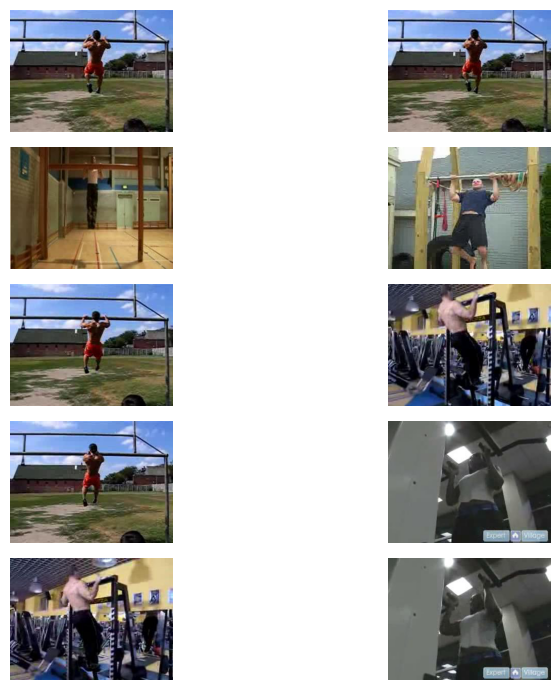

In [ ]:
show_image_collection(pullups_image_paths[:10], ncols=2)

### BodyWeightSquats

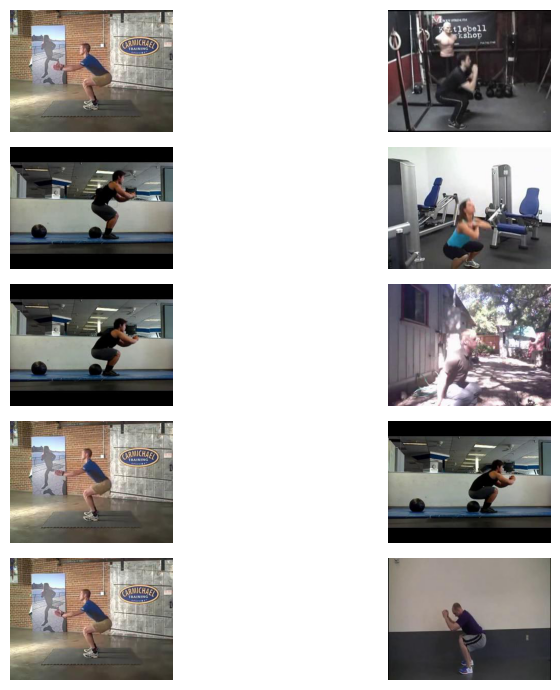

In [ ]:
show_image_collection(squats_image_paths[:10], ncols=2)

### PushUps

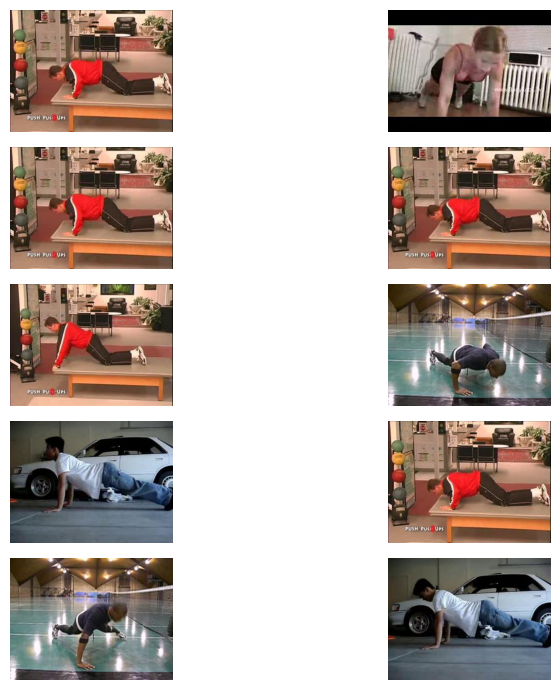

In [ ]:
show_image_collection(pushups_image_paths[:10], ncols=2)

## Create tensorflow dataset

### Datas & Labels

In [ ]:
# combine all exercise images
X = np.concatenate((pullups_image_paths, 
                    squats_image_paths, 
                    pushups_image_paths))

In [ ]:
# create classes and value mapping table
table = create_classes_index_table(CLASSES)

In [ ]:
table.lookup(tf.constant(["PullUps"])).numpy()[0]

0

In [ ]:
# create labels for pullups
pullup_cls_index = table.lookup(tf.constant(["PullUps"])).numpy()[0]
pullups_labels = np.full(shape=len(pullups_image_paths), 
                         fill_value=pullup_cls_index,
                         dtype=np.int8)

In [ ]:
# create labels for body weight squats
squats_cls_index = table.lookup(tf.constant(["BodyWeightSquats"])).numpy()[0]
squats_labels = np.full(shape=len(squats_image_paths), 
                         fill_value=squats_cls_index,
                         dtype=np.int8)

In [ ]:
# create labels for pullups
pushups_cls_index = table.lookup(tf.constant(["PushUps"])).numpy()[0]
pushups_labels = np.full(shape=len(pushups_image_paths), 
                         fill_value=pushups_cls_index,
                         dtype=np.int8)

In [ ]:
y = np.concatenate([pullups_labels,
                    squats_labels,
                    pushups_labels])

### Split data into train, validation and test set

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.2)

### Create training set

In [ ]:
# create train data generator
train_data_gen = ImageDataGenerator(X_train, y_train, copy=False)

# output signature
output_signature = (
    tf.TensorSpec(shape=plt.imread(X[0]).shape, dtype=tf.uint8),
    tf.TensorSpec(shape=y[0].shape, dtype=tf.uint8)
)

# create training dataset
train_dataset = tf.data.Dataset.from_generator(train_data_gen,
                                               output_signature=output_signature)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)\
                 .batch(BATCH_SIZE)\
                 .prefetch(PREFETCH_BUFFER_SIZE)

### Create validation set

In [ ]:
# create validation data generator
val_data_gen = ImageDataGenerator(X_val, y_val, copy=False)

# create validation dataset
val_dataset = tf.data.Dataset.from_generator(val_data_gen,
                                               output_signature=output_signature)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE)\
                 .batch(1)\
                 .prefetch(PREFETCH_BUFFER_SIZE)

### Create test set

In [ ]:
# create test data generator
test_data_gen = ImageDataGenerator(X_test, y_test, copy=False)

# create test dataset
test_dataset = tf.data.Dataset.from_generator(test_data_gen,
                                              output_signature=output_signature)
test_dataset = test_dataset.batch(1)\
                      .prefetch(PREFETCH_BUFFER_SIZE)

### Visualize dataset image and label 

In [ ]:
classes, indices = table.export()[0].numpy(), table.export()[1].numpy()

PushUps


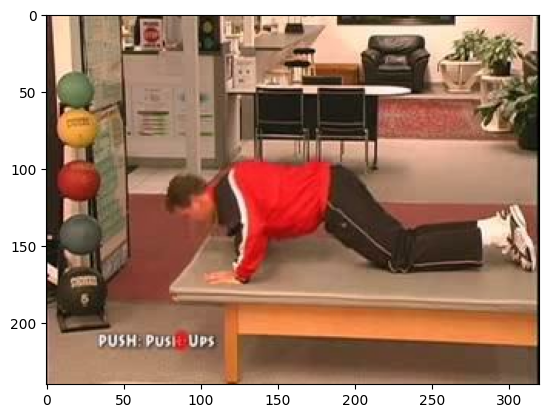

In [ ]:
for img, label in train_dataset.unbatch().take(1):
  print(classes[indices==label.numpy()][0].decode("utf8"))
  show_image(img)

PushUps


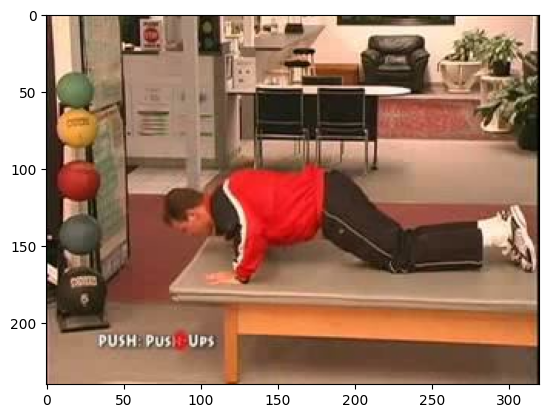

In [ ]:
for img, label in val_dataset.unbatch().take(1):
  print(classes[indices==label.numpy()][0].decode("utf8"))
  show_image(img)

# Create model

## Layers

### Movenet

#### Movenet layer

In [ ]:
import tensorflow_hub as hub
from keras import layers

class MovenetLayer(layers.Layer):
  def __init__(self, *args, **kwargs):
    """
    Movenet Keras layer.

    #
    What's Movenet https://www.tensorflow.org/hub/tutorials/movenet
    
    #
    Using Movenet model from tensorflow hub to
    produce 17 human body keypoints from input image
    https://tfhub.dev/google/movenet/singlepose/lightning/4

    #
    This layer take images as input and output 17 keypoints with
    each keypoint include y, x, confidence score where  y, x represent
    the keypoint on image and confidence score represent how confident is
    the keypoint

    ### Input:
    The shape of input must be 4 dimensions e.g `[3, 320, 240, 3]` where 
    first dimension is batch size, second and third dimensions are image's
    width and height, last dimension is image's color channel

    ### output:
    The shape of output is 3 dimensions e.g `[3, 17, 3]` where first
    dimension is batch size, second dimension is 17 keypoints and last
    dimension is y, x, confident score
    """
    super().__init__(*args, **kwargs)
    self.movenet_layer = hub.KerasLayer(
        "https://tfhub.dev/google/movenet/singlepose/lightning/4",
        signature="serving_default",
        output_key="output_0"
    )
  
  @tf.function
  def do_movenet(self, x):
    # cast dtype to int32 as input for movenet
    x = tf.cast(x, dtype=tf.int32)

    # resize input image
    x = tf.image.resize_with_crop_or_pad(x, 192, 192)

    # get movenet output
    movenet_output = self.movenet_layer(tf.expand_dims(x, axis=0))
    
    # reshape movenet output from [1,1,17,3] to
    # [17, 3] where 17 is keypoints and 3 is
    # [y, x, confident score]  
    return tf.reshape(movenet_output, [17, 3])

  def call(self, inputs, **kwargs):
    return tf.vectorized_map(self.do_movenet, inputs)

#### Test movenet layer

In [ ]:
# movenet_layer = MovenetLayer()

In [ ]:
# for input, label in train_dataset.unbatch().take(1):
#   print(table.export()[0][label.numpy()].numpy().decode("utf8"))
#   print(movenet_layer(tf.expand_dims(input, axis=0)))

## Models

### DNN

Baseline Deep Neural Network

Conclusion:
Model performance is good. However this model do not take uncertainty in to count which lead to model over confident

In [ ]:
from keras import Model, layers

class PoseRecognizer(Model):
  def __init__(self, num_classes, dropout_rate=0.2, **kargs):
    super(PoseRecognizer, self).__init__(**kargs)
    self.movenet_layer = MovenetLayer(name="Movenet")
    self.image_channels = 3
    self.flatten_layer = layers.Flatten()
    self.dense_layers = [
        layers.Dense(51, activation="relu", name="Dense1"),
        layers.Dropout(dropout_rate, name="Dropout1"),
        layers.Dense(51, activation="relu", name="Dense2"),
        layers.Dropout(dropout_rate, name="Dropout2"),
        layers.Dense(num_classes, activation="softmax", name="Output")
    ]

  def build(self, input_shape):
    super().build(input_shape)
    self.call(Input(shape=(192,192,3)))

  def call(self, inputs, training=None, mask=None):
    # check image channels
    if inputs.shape[-1] != 3:
      raise Exception(f"Input image must have 3 color channels (RGB) but given {inputs.shape[-1]}")
    
    # stitch layers
    x = self.movenet_layer(inputs)
    x = self.flatten_layer(x)
    for dense in self.dense_layers:
      x = dense(x)
    return x

### BNN

Bayesian Neural Network
  * Epistemic uncertainty
  * Each trainable weigths in network is a probablitity distribution instead of single weight value

References:

* https://towardsdatascience.com/modeling-uncertainty-in-neural-networks-with-tensorflow-probability-d519a4426e9c

Conclusion: This model do take uncertainty into count. Unfortunatly this model can not be convert to JS model for mobile device due to tensorflow probability library do not support JS version

#### Prior & Posterior

Specific for Bayesian Neural Network

In [ ]:
from keras import Model, layers
import tensorflow_probability as tfp


def prior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  prior_model = keras.Sequential([
      tfp.layers.DistributionLambda(
          lambda t: tfp.distributions.MultivariateNormalDiag(
              loc=tf.zeros(n), scale_diag=tf.ones(n)
          )
      )
  ])
  return prior_model


def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  posterior_model = keras.Sequential([
      tfp.layers.VariableLayer(
          tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
      ),
      tfp.layers.MultivariateNormalTriL(n),
  ])
  return posterior_model

#### BNN model

In [ ]:
from keras import Model, layers

class PoseRecognizerBayesian(Model):
  def __init__(self, num_classes, train_size, 
               dropout_rate=0.2, **kargs):
    super(PoseRecognizerBayesian, self).__init__(**kargs)
    self.movenet_layer = MovenetLayer(name="Movenet")
    self.batch_norm_layer = layers.BatchNormalization()
    self.dense_layers = [
        tfp.layers.DenseVariational(units=17,
                                    make_prior_fn=prior,
                                    make_posterior_fn=posterior,
                                    kl_weight=1.0/train_size,
                                    activation="sigmoid"),                
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax", name="Output")
    ]

  def build(self, input_shape):
    super().build(input_shape)
    self.call(Input(shape=(192,192,3)))

  def call(self, inputs, training=None, mask=None):
    # check image channels
    if inputs.shape[-1] != 3:
      raise Exception(f"Input image must have 3 color channels (RGB) but given {inputs.shape[-1]}")
    
    # stitch layers
    x = self.movenet_layer(inputs)
    x = self.batch_norm_layer(x)
    for dense in self.dense_layers:
      x = dense(x)
    return x

### SNGP

Reference:
* https://www.tensorflow.org/tutorials/understanding/sngp#about_sngp

Libraries:
* https://github.com/tensorflow/models/tree/master/official

In [3]:
! pip install --user -q tf-models-official
! pip install --user -q tensorflow-text

In [4]:
from keras.callbacks import Callback
class ResetCovarianceCallback(Callback):
  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the begining of the epoch."""
    if epoch > 0:
      self.model.gp_layer.reset_covariance_matrix()

In [5]:
from keras import Model, layers
import tensorflow_models as tfm

class PoseRecognizerSNGP(Model):
  def __init__(self, num_classes, dropout_rate=0.2, **kargs):
    super(PoseRecognizerSNGP, self).__init__(**kargs)
    self.movenet_layer = MovenetLayer(name="Movenet")
    self.image_channels = 3
    self.flatten_layer = layers.Flatten()
    self.spectral_layers = [
        tfm.nlp.layers.SpectralNormalization(
            layers.Dense(51, activation="selu")
        ),
        layers.Dropout(dropout_rate),
        tfm.nlp.layers.SpectralNormalization(
            layers.Dense(25, activation="selu")
        ),
        layers.Dropout(dropout_rate),
        tfm.nlp.layers.SpectralNormalization(
            layers.Dense(15, activation="selu")
        ),
        layers.Dropout(dropout_rate), 
    ]
    self.gp_layer = tfm.nlp.layers.RandomFeatureGaussianProcess(units=num_classes,
                                                                gp_cov_momentum=-1)
    self.output_layer = layers.Dense(num_classes, activation="softmax", 
                                     name="output")

  def build(self, input_shape):
    super().build(input_shape)
    self.call(layers.Input(shape=(192,192,3)))

  def call(self, inputs, training=None, mask=None):
    # check image channels
    if inputs.shape[-1] != 3:
      raise Exception(f"Input image must have 3 color channels (RGB) but given {inputs.shape[-1]}")
    
    # stitch layers
    x = self.movenet_layer(inputs)
    x = self.flatten_layer(x)
    for spec_layer in self.spectral_layers:
      x = spec_layer(x, training=training)

    # RandomFeatureGaussianProcess return
    # logit, covariance matrix   
    x, cov_mat = self.gp_layer(x, training=training)
    x = self.output_layer(x)
    return x

/root/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Train model

In [ ]:
def get_model(X_train_size):
  model = PoseRecognizerSNGP(num_classes=3,
                              name='PoseRecognizerSNGP')

  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])
  return model

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

tf.random.set_seed(42)

keras.backend.clear_session()
  
pose_model = get_model(len(X_train))

# reduce learning rate
reduce_lr = ReduceLROnPlateau(min_lr=1e-8, patience=3, verbose=1)

# early stop
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# reset covariance at each epoch begin
rest_covar_cb = ResetCovarianceCallback()

In [ ]:
from keras import Input

pose_model.build(input_shape=(BATCH_SIZE,192,192,3))
pose_model.summary(show_trainable=True)

Model: "PoseRecognizerSNGP"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 Movenet (MovenetLayer)      (None, 17, 3)             0         Y          
                                                                            
 flatten (Flatten)           (None, 51)                0         Y          
                                                                            
 spectral_normalization (Spe  (None, 51)               2754      Y          
 ctralNormalization)                                                        
                                                                            
 dropout (Dropout)           (None, 51)                0         Y          
                                                                            
 spectral_normalization_1 (S  (None, 25)               1376      Y          
 pectralNormalization)                          

In [ ]:
history = pose_model.fit(x=train_dataset,
                        epochs=EPOCHS,
                        steps_per_epoch=len(X_train)//BATCH_SIZE,
                        validation_data=val_dataset,
                        validation_steps=len(X_val),
                        callbacks=[reduce_lr, 
                                    early_stop,
                                   rest_covar_cb])

Epoch 1/30
16/16 [==============================] - 101s 5s/step - loss: 1.0580 - accuracy: 0.4883 - val_loss: 0.9934 - val_accuracy: 0.4408 - lr: 0.0010
Epoch 2/30
16/16 [==============================] - 70s 4s/step - loss: 0.9400 - accuracy: 0.5889 - val_loss: 0.8350 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 3/30
16/16 [==============================] - 67s 4s/step - loss: 0.7883 - accuracy: 0.6875 - val_loss: 0.6503 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 4/30
16/16 [==============================] - 67s 4s/step - loss: 0.6464 - accuracy: 0.7559 - val_loss: 0.5428 - val_accuracy: 0.7488 - lr: 0.0010
Epoch 5/30
16/16 [==============================] - 66s 4s/step - loss: 0.5332 - accuracy: 0.8135 - val_loss: 0.4523 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 6/30
16/16 [==============================] - 64s 4s/step - loss: 0.4600 - accuracy: 0.8555 - val_loss: 0.3700 - val_accuracy: 0.9052 - lr: 0.0010
Epoch 7/30
10/16 [=================>............] - ETA: 18s - loss: 0.4046 - acc

In [ ]:
plot_history(history.history, accuracy_name="accuracy")

# Evaluate model

In [ ]:
pose_model.evaluate(test_dataset, steps=len(X_test))

# Make prediction

In [ ]:
for img, label in test_dataset.unbatch().take(1):
  y_true_label = classes[indices==label.numpy()][0].decode("utf8")
  print(f"True label: {y_true_label}")
  y_pred = tf.squeeze(pose_model.predict(tf.expand_dims(img, axis=0),
                                         verbose=0))
  y_prob = np.round(np.max(y_pred), 2)
  y_pred = np.argmax(y_pred)
  y_label = classes[indices==y_pred][0].decode("utf8")
  print(f"predict: {y_label}, confidence: {y_prob * 100} %")
  show_image(img)

# Analyse test set probability distribution

In [ ]:
# get prediction probability for each instances
pred_probs = []
for img, label in test_dataset.unbatch().take(len(X_test)):
  y_probs = tf.squeeze(pose_model.predict(tf.expand_dims(img, axis=0), 
                                          verbose=0))
  pred_probs.append(tf.reduce_max(y_probs).numpy())

# plot distribution
plot_dist(x=pred_probs, 
          title="Test set prediction distribution",
          xticks=np.round(np.linspace(0.0, 1.0, num=11), 1),
          mean=np.mean(pred_probs))

# Analyse in domain probability distribution


In [ ]:
in_domain_ds_name = "BodyWeightSquats"
test_image_paths = save_frame_from_videos(DATASET_DIR, 
                                             f"**/*{in_domain_ds_name}*.avi",
                                             os.path.join(DATASET_DIR, "TestImages"),  
                                             0.08)

In [ ]:
# get prediction probability for each instances
pred_probs = []
for img_path in test_image_paths:
  img = tf.io.decode_image(tf.io.read_file(img_path))
  y_probs = tf.squeeze(pose_model.predict(tf.expand_dims(img, axis=0),
                                          verbose=0))
  pred_probs.append(tf.reduce_max(y_probs).numpy())

# plot distribution
plot_dist(x=pred_probs, 
          title=f"{in_domain_ds_name} prediction distribution",
          xticks=np.round(np.linspace(0.0, 1.0, num=11), 1),
          mean=np.mean(pred_probs))

# Analyse OOD probability distribution

Probability distribution for out of domain. Dataset that is not in training set


In [ ]:
ood_ds_name = "Archery"
test_image_paths = save_frame_from_videos(DATASET_DIR, 
                                             f"**/*{ood_ds_name}*.avi",
                                             os.path.join(DATASET_DIR, "TestImages"),  
                                             0.08)

In [ ]:
# get prediction probability for each instances
pred_probs = []
for img_path in test_image_paths:
  img = tf.io.decode_image(tf.io.read_file(img_path))
  y_probs = tf.squeeze(pose_model.predict(tf.expand_dims(img, axis=0),
                                          verbose=0))
  pred_probs.append(tf.reduce_max(y_probs).numpy())

# plot distribution
plot_dist(x=pred_probs, 
          title=f"{ood_ds_name} \nInstances:{len(pred_probs)}",
          xticks=np.round(np.linspace(0.0, 1.0, num=11), 1),
          mean=np.mean(pred_probs))

# Save model

In [ ]:
# save model
tf_model_dir_path = os.path.join(SAVE_MODEL_ROOT_DIR, TF_MODEL_DIR)
pose_model.save(tf_model_dir_path)

#Test

In [ ]:
from keras import Model, layers, Input

model = PoseRecognizerBayesian(3, 1000,name='PoseRecognizerBayesian')
model.build(input_shape=(BATCH_SIZE,192,192,3))
model.summary()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((np.random.rand(1000, 100,100,3), 
                                         np.random.randint(0, 3, 1000))).batch(BATCH_SIZE)
model.fit(ds,
          epochs=1)

In [ ]:
tf_model_dir_path = os.path.join(SAVE_MODEL_ROOT_DIR, TF_MODEL_DIR)
model.save(tf_model_dir_path, save_format="tf")

# converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_dir_path)
# tflite_model = converter.convert()

# tflite_model_filepath = os.path.join(SAVE_MODEL_ROOT_DIR,
#                                      TFLITE_MODEL_DIR,
#                                      "pose_recognizer.tflite")
# os.makedirs(os.path.join(SAVE_MODEL_ROOT_DIR,
#                                      TFLITE_MODEL_DIR),
#             exist_ok=True)
# with open(tflite_model_filepath, 'wb') as f:
#   f.write(tflite_model)

In [ ]:
 ! pip install -U -q tensorflowjs

# Convert to JS model

https://github.com/tensorflow/tfjs/tree/master/tfjs-converter

In [ ]:
! tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    /content/Saved_models/tf_pose_recognizer \
    /content/Saved_models/js_model